# German → English Machine Translation Results

This notebook presents training curves, evaluation metrics, and qualitative outputs
for Seq2Seq and Transformer models trained on the Multi30k dataset.

## 1. Experiment Setup

- Dataset: Multi30k (German → English)
- Vocabulary: built from training split
- Evaluation metric: BLEU-4
- Decoding: Greedy decoding

In [8]:
import torch
import matplotlib.pyplot as plt
import os
from utils.bleu import evaluate_bleu
from data.dataset import train_data,test_data,Tokenize_de,Tokenize_en,vocab_de,vocab_en,itow_en,SOS_IDX,EOS_IDX,PAD_IDX
from models.Transformer import Transformer
from train.Transformer_train import EMBED_SIZE,NUM_LAYERS,MAX_LEN,HEADS,EXPANSION,DROPOUT
from utils.greedy_s2s import translate_sentence_greedy_seq2seq
from models.Seq2Seq import Seq2Seq,Encoder,Decoder
from utils.greedy_transformer import translate_sentence_greedy_transformer

## 2. Training Loss Curves

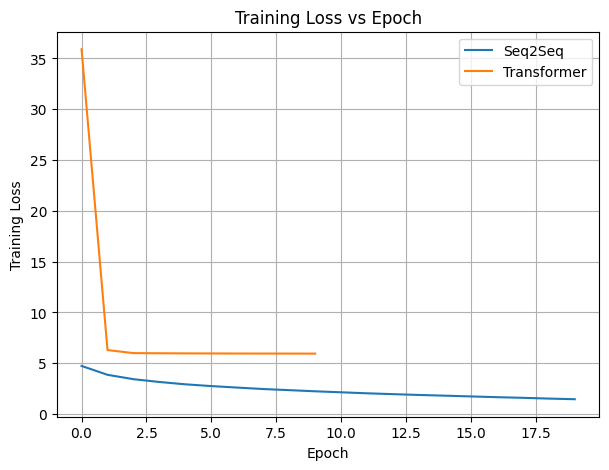

In [9]:
checkpoint_path_s2s="weights/seq2seq.pt"
checkpoint_s2s=torch.load(checkpoint_path_s2s, map_location="cpu")
train_losses_s2s=checkpoint_s2s["train_losses"]

checkpoint_path_t="weights/transformer.pt"
checkpoint_t=torch.load(checkpoint_path_t,map_location="cpu")
train_losses_t=checkpoint_t["train_losses"]

plt.figure(figsize=(7,5))
plt.plot(train_losses_s2s, label="Seq2Seq")
plt.plot(train_losses_t, label="Transformer")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()



## 3. BLEU Score Evaluation

In [10]:
HIDDEN_DIM=256
NUM_LAYERS=2
TF_RATIO=0.5
encoder=Encoder(
    hidden_dim=HIDDEN_DIM,
    vocab_size=len(vocab_de),
    num_layers=NUM_LAYERS
)
decoder=Decoder(
    hidden_dim=HIDDEN_DIM,
    vocab_size=len(vocab_en),
    num_layers=NUM_LAYERS
)
model=Seq2Seq(
    encoder=encoder,
    decoder=decoder,
    tf_ratio=TF_RATIO
)
CHECKPOINT_PATH="weights/seq2seq.pt"
checkpoint = torch.load(CHECKPOINT_PATH,map_location="cpu")
model.load_state_dict(checkpoint["model_state"])
model.eval()

bleu=evaluate_bleu(
    model=model,
    data=test_data,
    tokenize_src=Tokenize_de,
    tokenize_tgt=Tokenize_en,
    vocab_src=vocab_de,
    itos_tgt=itow_en,
    sos_idx=SOS_IDX,
    eos_idx=EOS_IDX,
    translate_fn=translate_sentence_greedy_seq2seq
)

print(f"BLEU SCORE Seq2Seq : {bleu*100:.2f}")

BLEU SCORE Seq2Seq : 27.73


## 4. Sample translations for seq2seq

In [11]:
print("Train translation")
print('-'*50)
for i in range(3):
    src = train_data[i+5]["de"]
    ref = train_data[i+5]["en"]

    pred = translate_sentence_greedy_seq2seq(
        sentence=src,
        model=model,
        tokenize_src=Tokenize_de,
        vocab_src=vocab_de,
        itos_tgt=itow_en,
        sos_idx=SOS_IDX,
        eos_idx=EOS_IDX,
    )

    print(f"SRC : {src}")
    print(f"REF : {ref}")
    print(f"PRED: {pred}")
    print('-'*50)

Train translation
--------------------------------------------------
SRC : Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht.
REF : A man in green holds a guitar while the other man observes his shirt.
PRED: a man in green holds a guitar while the other man is looking at his .
--------------------------------------------------
SRC : Ein Mann lächelt einen ausgestopften Löwen an.
REF : A man is smiling at a stuffed lion
PRED: a man is smiling at a blue lion .
--------------------------------------------------
SRC : Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt.
REF : A trendy girl talking on her cellphone while gliding slowly down the street.
PRED: a trendy girl talking on her cellphone while walking down the street .
--------------------------------------------------


In [12]:
print("Test translation")
print('-'*50)
for i in range(3):
    src = test_data[i+10]["de"]
    ref = test_data[i+10]["en"]

    pred = translate_sentence_greedy_seq2seq(
        sentence=src,
        model=model,
        tokenize_src=Tokenize_de,
        vocab_src=vocab_de,
        itos_tgt=itow_en,
        sos_idx=SOS_IDX,
        eos_idx=EOS_IDX,
    )

    print(f"SRC : {src}")
    print(f"REF : {ref}")
    print(f"PRED: {pred}")
    print('-'*50)

Test translation
--------------------------------------------------
SRC : Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.
REF : A mother and her young song enjoying a beautiful day outside.
PRED: a mother and her son enjoying a beautiful day outside .
--------------------------------------------------
SRC : Männer, die Volleyball spielen, wobei ein Mann den Ball nicht trifft, während seine Hände immer noch in der Luft sind.
REF : Men playing volleyball, with one player missing the ball but hands still in the air.
PRED: men volleyball volleyball game , one man the ball , the one is raises his arms in the air .
--------------------------------------------------
SRC : Eine Frau, die in einer Küche eine Schale mit Essen hält.
REF : A woman holding a bowl of food in a kitchen.
PRED: a woman in a kitchen with a food in the kitchen .
--------------------------------------------------
